In [1]:
# -*- coding: utf-8 -*-
import os
import makeDataset
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import cv2
from IPython import display
import random


#from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline


emptyMnist = makeDataset.dataSet([])

with open("./testImage.data" , 'rb') as f:
    testImage = pickle.load(f)
with open("./testLabel.data" , 'rb') as f:
    testLabel = pickle.load(f)
with open("./trainImage.data" , 'rb') as f:
    trainImage = pickle.load(f)
with open("./trainLabel.data" , 'rb') as f:
    trainLabel = pickle.load(f)    

with open("./testAnswer.data" , 'rb') as f:
    testAnswer = pickle.load(f)
    
    
emptyMnist.train.images = trainImage
emptyMnist.train.labels = trainLabel
emptyMnist.test.images = testImage
emptyMnist.test.labels = testLabel
mnist = emptyMnist
mnist.train.num_examples = len(mnist.train.labels)
mnist.test.num_examples = len(mnist.test.labels)
numOfTests = len(mnist.test.labels)

print("원본 이미지 사이즈는 682 X 700 입니다.")
print("64 X 64 로 리사이즈 되었습니다.")
print("각각의 좌표는 0.00 ~ 1.0 로 스케일 하였습니다.")
print("실제 좌표와 추정 좌표가 잘 맞는지 확인 하기 위해서 testAnswer를 사용 합니다")
print("다시 좌표를 복원 할때는 175X170 사이즈를 고려 하여 스케일 해 주어야 합니다")

원본 이미지 사이즈는 682 X 700 입니다.
64 X 64 로 리사이즈 되었습니다.
각각의 좌표는 0.00 ~ 1.0 로 스케일 하였습니다.
실제 좌표와 추정 좌표가 잘 맞는지 확인 하기 위해서 testAnswer를 사용 합니다
다시 좌표를 복원 할때는 175X170 사이즈를 고려 하여 스케일 해 주어야 합니다


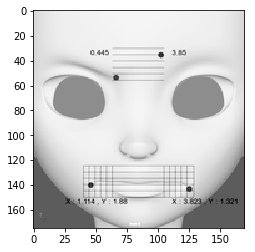

In [2]:
plt.imshow(testAnswer[0].reshape((175,170))*-1, cmap='Greys')

In [22]:
# 변수들을 설정한다.
keep_prob = tf.placeholder(tf.float32)
x = tf.placeholder(tf.float32, [None, 4096])
x = tf.nn.dropout(x, keep_prob)
W1 = tf.Variable(tf.random_normal([4096, 300] , stddev=0.001))
b1 = tf.Variable(tf.zeros([300]))
y1 = tf.matmul(x, W1) + b1
y1 = tf.nn.relu(y1+0.000001)

W2 = tf.Variable(tf.random_normal([300, 100] , stddev=0.001))
b2 = tf.Variable(tf.zeros([100])) 
y2 = tf.matmul(y1, W2) + b2 
y2 = tf.nn.relu(y2+0.000001)

W3 = tf.Variable(tf.random_normal([100, 100] , stddev=0.001))
b3 = tf.Variable(tf.zeros([100])) 
y3 = tf.matmul(y2, W3) + b3
y3 = tf.nn.relu(y3+0.000001)


W4 = tf.Variable(tf.random_normal([100, 8] , stddev=0.001))
b4 = tf.Variable(tf.zeros([8])) 
y4 = tf.matmul(y3, W4) + b4
y5 = y4

In [23]:
# cross-entropy 모델을 설정한다.
y_ = tf.placeholder(tf.float32, [None, 8])
#cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y5), reduction_indices=[1]))
cost = tf.reduce_mean(tf.square( y_ - y5))
learning_rate = tf.placeholder(tf.float32, shape=[])
#train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)#
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [24]:
# 경사하강법으로 모델을 학습한다.
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [25]:
def testMnist(cost , y , images ,labels ,indexes , NumOfShow ):
    # 학습된 모델이 얼마나 정확한지를 출력한다.
    if len(images) == 0:
        return None
    else:
        result = sess.run([cost , y] , feed_dict={x: images, y_: labels})
        for i in range(NumOfShow):
            lb = result[1][i]
            image = testAnswer[indexes[i]].reshape((175,170))*-1
            for ii , l in enumerate(lb):
                if ii%2 == 0:
                    yy = int(l*175.0) # Y 리스케일링
                else:
                    xx = int(l*170.0) # X 리스케일링
                    cv2.circle(image,(yy , xx), 1, (0,255,0), -1)#테스트 이미지에 좌표를 그려준다
            plt.imshow(image, cmap='Greys')#테스트 이미지 출력
            display.display(plt.gcf())#이미지를 실시간으로 표현한다
        return result[0]

In [26]:
def run(epoch = 500 ,checkpoint = [50,10] ,numOfTest = 50 , showCnt = 1 ,lr = 0.001):
    global cost,mnist
    costs = []
    test_images = []
    test_labels = []
    indexes = []
    train_Images = []
    #train_Labels = []
    for i in range(epoch):
        if i%checkpoint[1] == 0:
            costs.append(testMnist(cost , y5 , test_images , test_labels  , indexes , 0 ))


        if i%checkpoint[0] == 0 :
            print("train epoch is " , i)
            print("cost : " , costs)
            costs=[]
            test_images = []
            test_labels = []
            indexes = []
            for _ in range(numOfTest):
                index = random.randrange(0,numOfTests)
                indexes.append(index)
                test_images.append(mnist.test.images[index])
                test_labels.append(mnist.test.labels[index])

            testMnist(cost , y5 , test_images , test_labels  , indexes , showCnt )
        #batch_xs, batch_ys = mnist.next_batch(100)
        sess.run(train_step, feed_dict={x: mnist.train.images , y_: mnist.train.labels , learning_rate: lr ,keep_prob: 0.7})

train epoch is  0
cost :  [None]


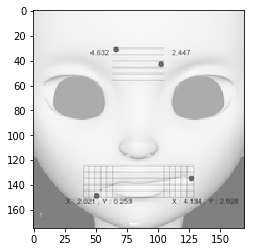

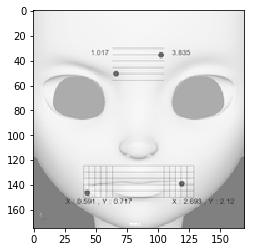

train epoch is  30
cost :  [0.060634036, 0.022191629, 0.0090596126]


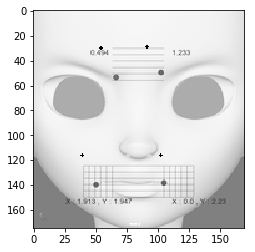

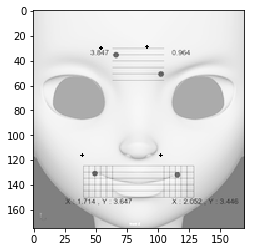

train epoch is  60
cost :  [0.0048217322, 0.001424449, 0.0014546704]


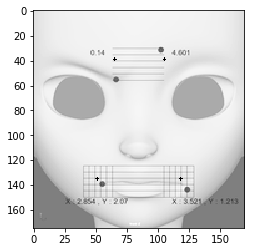

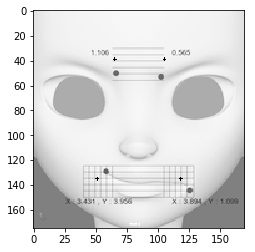

train epoch is  90
cost :  [0.0013046189, 0.0012613008, 0.0012501839]


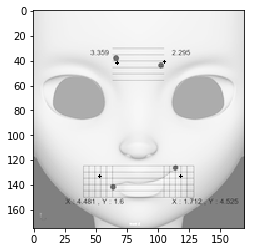

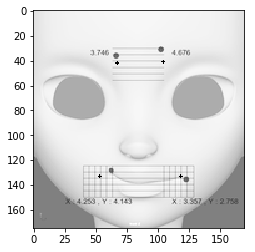

train epoch is  120
cost :  [0.0012840034, 0.0012749454, 0.0012776074]


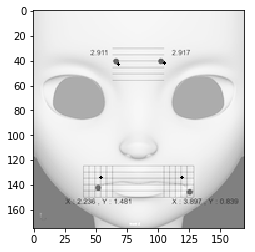

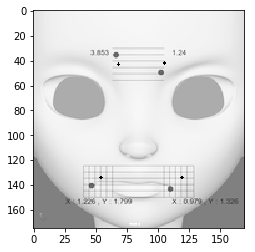

train epoch is  150
cost :  [0.0013877681, 0.0013857927, 0.0013859946]


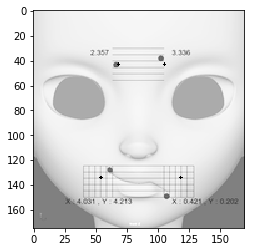

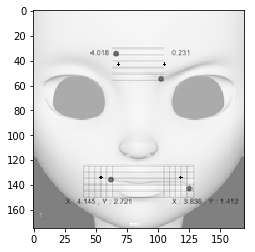

train epoch is  180
cost :  [0.0012719658, 0.0012712756, 0.0012715656]


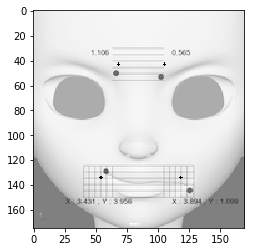

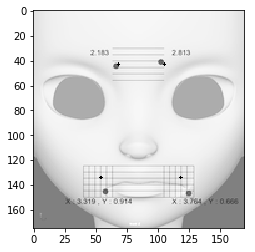

train epoch is  210
cost :  [0.0013140782, 0.0013138659, 0.0013137965]


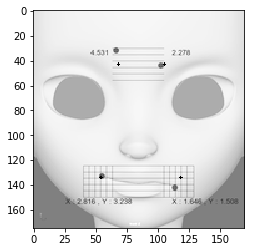

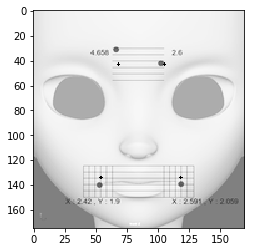

train epoch is  240
cost :  [0.0013145697, 0.0013144766, 0.0013144094]


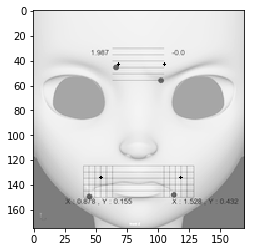

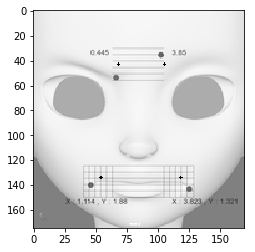

KeyboardInterrupt: 

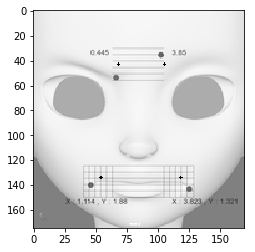

In [27]:
run(epoch=50000,checkpoint = [30,10] , showCnt = 2 , lr = 0.0001 )